# Master Thesis

Datasets:
- medical dataset: https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions/data
- pii masking hugging face dataset: https://huggingface.co/datasets/ai4privacy/pii-masking-65k/viewer/default/train?row=2

Github:
- https://github.com/kkdresen/masterds_thesis

In [1]:
!pip install lime


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


### Packages

In [4]:
# Basic libraries

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
import random
import itertools
from collections import defaultdict
from nltk.tokenize import sent_tokenize, word_tokenize
import seaborn as sns

In [ ]:
# Preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import combinations
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN

: 

### Load in Medical Data

In [6]:
path = "/Users/kyradresen/MasterThesis_MedTextPrivacy/data/mtsamples.csv"
data = pd.read_csv(path)
print(data.shape)
data.head()

(4999, 6)


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4999 non-null   int64 
 1   description        4999 non-null   object
 2   medical_specialty  4999 non-null   object
 3   sample_name        4999 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3931 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


### Missing Values

In [8]:
def count_nan_values(data_frame, column_names):
    """
    Counts the number of NaN values in the specified column(s) of the given DataFrame.

    Parameters:
    - data_frame (pd.DataFrame): The DataFrame to analyze.
    - column_names (str or list): The name of the column or a list of column names to check for NaN values.

    Returns:
    - A dictionary with column names as keys and the count of NaN values as values. If a single column name is provided,
      a direct count is returned.
    """
    if isinstance(column_names, str):
        # If a single column name is provided, return the count directly
        return data_frame[column_names].isna().sum()
    elif isinstance(column_names, list):
        # If a list of column names is provided, return a dictionary with counts
        return {column: data_frame[column].isna().sum() for column in column_names}
    else:
        raise ValueError("The column_names parameter should be either a string or a list of strings.")

In [9]:
count = count_nan_values(data, 'transcription')
print(f"Number of NaN values in 'column_name': {count}")

Number of NaN values in 'column_name': 33


In [10]:
# to identify the null values by descending order
data.isnull().sum().sort_values(ascending = False)

keywords             1068
transcription          33
Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
dtype: int64

As there are 33 rows with NaN values in transcription these should be removed, as transcription is the sole column we focus on in the rest of the research

### Drop rows and columns

The dataset contains of several categories, but we will need only transcription, and medical_specialty, which is the target disgnostics type.

In [11]:
data = data[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.head(2)

,transcription,medical_specialty
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Bariatrics


## Data review

In [12]:
data['medical_specialty'].value_counts()

medical_specialty
Surgery                          1088
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Discharge Summary                 108
ENT - Otolaryngology               96
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    61
Psychiatry / Psychology            53
Office Notes                       50
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                       

In [13]:
def get_sentence_word_count(transcriptions):
    sentence_count = sum(len(sent_tokenize(text)) for text in transcriptions)
    words = [word for text in transcriptions for word in word_tokenize(text)]
    unique_words = set(words)
    return sentence_count, len(unique_words)

# Filter out rows where 'transcription' is NaN
data = data[data['transcription'].notna()]

# Convert 'transcription' column to a list of strings for processing
transcriptions = data['transcription'].tolist()

# Get sentence and unique word counts
sent_count, word_count = get_sentence_word_count(transcriptions)

print("Number of sentences in transcriptions column: " + str(sent_count))
print("Number of unique words in transcriptions column: " + str(word_count))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kyradresen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Number of sentences in transcriptions column: 147006
Number of unique words in transcriptions column: 41910


In [14]:
# Ensure NLTK resources are downloaded (only need to do this once)
nltk.download('punkt')

def analyze_transcription_metrics(transcription):
    # Tokenize the transcription into sentences and words
    sentences = sent_tokenize(transcription)
    words = word_tokenize(transcription)

    # Calculate metrics
    word_count = len(words)
    mean_word_length = sum(len(word) for word in words) / word_count
    mean_sentence_length = sum(len(sentence.split()) for sentence in sentences) / len(sentences)
    length_of_sample_review = len(transcription)  # Length of the sample review

    return {
        "Word count": word_count,
        "Mean word length": mean_word_length,
        "Mean sentence length": mean_sentence_length,
        "Length of sample review": length_of_sample_review,
        "Number of words in review": word_count,  # This is the same as word_count
        "Avg length of words": mean_word_length,  # This is the same as mean_word_length
        "Avg length of sentences in review": mean_sentence_length,  # Same as mean_sentence_length
    }

# Assuming 'data' is your DataFrame and it has a 'transcription' column
# Filter out rows where 'transcription' is NaN
data = data[data['transcription'].notna()]

# Apply the analysis to each transcription and create a new DataFrame with the results
metrics = data['transcription'].apply(analyze_transcription_metrics)
metrics_df = pd.DataFrame(metrics.tolist())

# Calculate mean, min, and max for each metric
metrics_summary = pd.DataFrame({
    "Mean": metrics_df.mean(),
    "Min": metrics_df.min(),
    "Max": metrics_df.max()
})

print(metrics_summary)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kyradresen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                          Mean    Min           Max
Word count                          553.022553   3.00   3489.000000
Mean word length                      4.649653   3.25      7.333333
Mean sentence length                 16.921946   1.00    114.000000
Length of sample review            3052.314337  11.00  18425.000000
Number of words in review           553.022553   3.00   3489.000000
Avg length of words                   4.649653   3.25      7.333333
Avg length of sentences in review    16.921946   1.00    114.000000


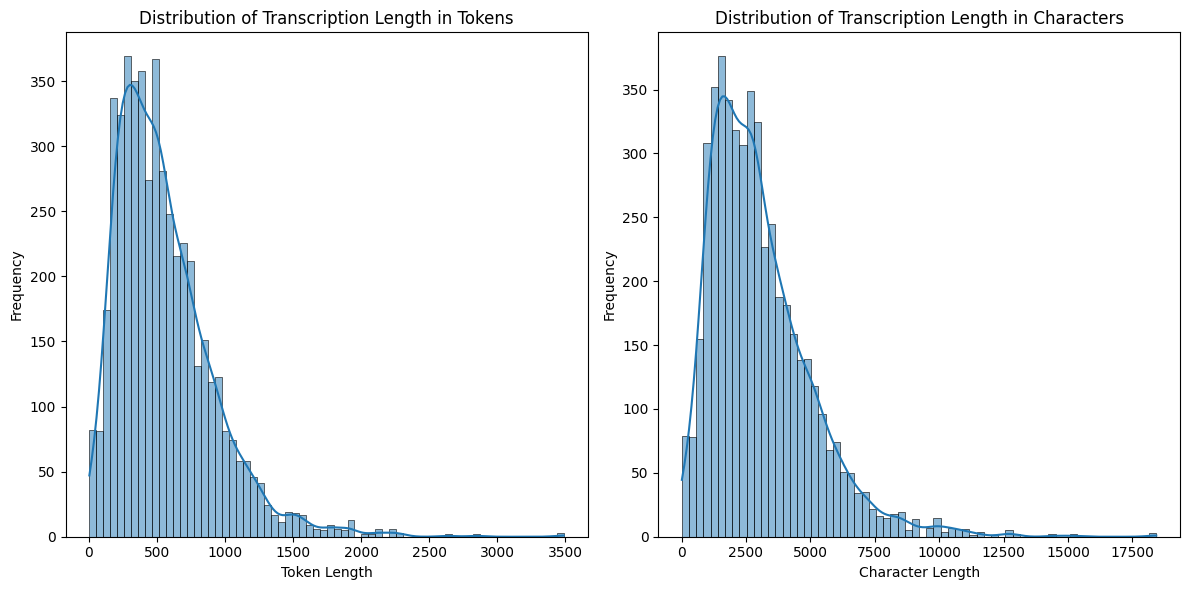

In [17]:
def analyze_transcription_lengths(transcription):
    """
    Analyze the length of a transcription in both tokens and characters.

    :param transcription: The transcription text.
    :return: A dictionary with token and character lengths.
    """
    tokens = word_tokenize(transcription)
    token_length = len(tokens)
    character_length = len(transcription)

    return {
        "Token Length": token_length,
        "Character Length": character_length
    }

# Assuming 'data' is your DataFrame and it has a 'transcription' column
# Filter out rows where 'transcription' is NaN
data = data[data['transcription'].notna()]

# Apply the analysis to each transcription and create a new DataFrame with the results
length_metrics = data['transcription'].apply(analyze_transcription_lengths)
length_metrics_df = pd.DataFrame(length_metrics.tolist())

def plot_transcription_length_distributions(length_metrics_df):
    """
    Plot the distribution of transcription lengths in tokens and characters.

    :param length_metrics_df: DataFrame with 'Token Length' and 'Character Length' columns.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot token length distribution
    sns.histplot(length_metrics_df['Token Length'], ax=ax[0], kde=True)
    ax[0].set_title('Distribution of Transcription Length in Tokens')
    ax[0].set_xlabel('Token Length')
    ax[0].set_ylabel('Frequency')

    # Plot character length distribution
    sns.histplot(length_metrics_df['Character Length'], ax=ax[1], kde=True)
    ax[1].set_title('Distribution of Transcription Length in Characters')
    ax[1].set_xlabel('Character Length')
    ax[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Plotting the distributions
plot_transcription_length_distributions(length_metrics_df)